In [1]:
from keras_preprocessing.sequence import pad_sequences
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import sys
import numpy as np
from keras.models import Sequential
from keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None
sys.path.append('../')
if os.path.abspath(os.pardir) not in sys.path:
    sys.path.append(os.path.abspath(os.pardir))

from preprocessing import Preprocessor

ROOT_DIR = os.path.dirname(os.getcwd())
DATA_DIR = os.path.join(ROOT_DIR, 'data', 'carer_emotion_dataset')
print(DATA_DIR)

label2int = {
  "sadness": 0,
  "joy": 1,
  "love": 2,
  "anger": 3,
  "fear": 4,
  "surprise": 5
}

2021-12-16 18:28:13.048910: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-16 18:28:13.048950: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


/home/daphne/PycharmProjects/sentiment_task/data/carer_emotion_dataset


## Load dataset

In [2]:
training_data = pd.read_csv(os.path.join(DATA_DIR, 'training.csv'), encoding='utf8')
test_data = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'), encoding='utf8')
validation_data = pd.read_csv(os.path.join(DATA_DIR, 'validation.csv'), encoding='utf8')

dataset = pd.concat([training_data, test_data, validation_data], ignore_index=True)
dataset = dataset.sample(frac=1)
print(dataset.head())
print(dataset.shape)
print(dataset.columns)

                                                    text  label
8097   i said it pops up every once in a while that d...      0
6534   i feel rather stressed for the preparations fo...      3
13153                     i go to bed feeling triumphant      1
8182   i feel paranoid because nobody is saying anything      4
1911   i am feeling i still should be caring and conc...      2
(20000, 2)
Index(['text', 'label'], dtype='object')


In [3]:
corpus = []
for i, row in dataset.iterrows():
    preprocessor = Preprocessor(row['text'])
    words_list = preprocessor.get_preprocessed_list_words()
    text = ' '.join(words_list)
    corpus.append(text)

y = np.array(dataset['label'].tolist())
X = np.array(corpus, dtype=str)
# X = np.reshape(X, (len(corpus), 1)).tolist()
y = np.reshape(y, (len(dataset), 1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [4]:
y_train_modified = to_categorical(y_train)
y_test_modified = to_categorical(y_test)
print(y_train.shape)
print(y_train_modified)

(15000, 1)
[[0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]


In [5]:
# url_regex = r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"
# special_chars = r"[^a-zA-Z0-9\s]+"
# html_tags = r'<.*?>'
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_tok = tokenizer.texts_to_sequences(X_train)
X_test_tok = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(X_train[2])
print(X_train_tok[2])

maxlen = 100

X_train = pad_sequences(X_train_tok, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test_tok, padding='post', maxlen=maxlen)

print(X_train[0, :])


think im mad feel jade five month nursing
[12, 3, 341, 1, 895, 896, 157, 2082]
[ 682 4172 4173    1  133 2544    6 1139  873 4174   28  402    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [15]:
embedding_dim = 50
input_dim = vocab_size
output_dim = embedding_dim
input_length = X_train.shape[1]

tf.keras.backend.clear_session()
model = Sequential()
model.add(layers.Embedding(input_dim=input_dim,
                           output_dim=output_dim,
                           input_length=input_length))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(6, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           599200    
                                                                 
 flatten (Flatten)           (None, 5000)              0         
                                                                 
 dense (Dense)               (None, 64)                320064    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               3

In [16]:
ts = TensorBoard(log_dir="./tensorboard_logs_dnn_emb", histogram_freq=5)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint(os.path.join(ROOT_DIR, 'models/best_model_dnn_emb.h5'), monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train_modified,
                    epochs=15,
                    verbose=True,
                    # validation_data=(X_test, y_test_modified),
                    batch_size=512,
                    validation_split=0.3,
                    callbacks=[ts, mc, es]
                    )

Epoch 1/15
20/21 [===========================>..] - ETA: 0s - loss: 1.6278 - accuracy: 0.3225 
Epoch 00001: val_loss improved from inf to 1.58707, saving model to /home/daphne/PycharmProjects/sentiment_task/models/best_model_dnn_emb.h5
21/21 [==============================] - 2s 51ms/step - loss: 1.6265 - accuracy: 0.3224 - val_loss: 1.5871 

In [ ]:
best_model = tf.keras.models.load_model(os.path.join(ROOT_DIR, 'models/best_model_dnn_emb.h5'))
loss, accuracy = model.evaluate(X_train, y_train_modified, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test_modified, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

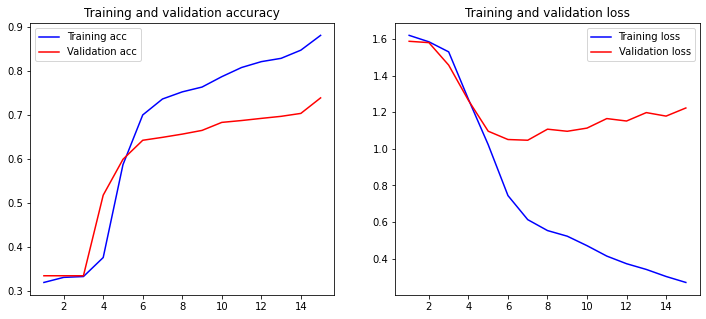

In [12]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)